In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.2 MB/s 
     |████████████████████████████████| 131 kB 46.7 MB/s 
     |████████████████████████████████| 7.9 MB 22.0 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 49.8 MB/s 
     |████████████████████████████████| 127 kB 47.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla K80 GPUs


# Test

In [5]:
save_path = '/content/drive/MyDrive'
df_test = pd.read_csv(save_path + '/test.csv')

In [6]:
df_test.head(10)

,id,task,ans
0,0,Вопрос 1 Денис готовится провести соревнования...,0
1,1,Реши задачу.\nСколько коробок корма для собак ...,3
2,2,"Если групп элементов несколько, то применяется...",0
3,3,Вопрос1 ...,3
4,4,Для наглядной геометрической иллюстрации объём...,0
5,5,Реши задачу в тетради.\nДима осваивал новый ме...,0
6,6,Вопрос1\nВыполни следующие задания.\nВычисли с...,2
7,7,Перед тобой лежит карта возможных маршрутов дв...,0
8,8,На первом участке дороги машина ехала 2 ч со с...,0
9,9,Скорость гребцов по течению реки составляет 23...,0


# Wiki

In [ ]:
import json
import pandas as pd

with open(save_path + '/aiijc_comand_data.json', 'r') as f :
  data = json.load(f)
df = pd.DataFrame(data)

In [ ]:
df.head()

,texts,links
животные,[Живо́тные (лат. Animalia) — традиционно (со в...,"[Волосатики, Национальная парламентская библио..."
музыка,"[Му́зыка (греч. μουσική, субстантивированное п...","[Мини-альбом, Волчья квинта, Ре (нота), Музыка..."
спорт,"[Спорт (англ. sport, сокращение от первоначаль...","[Олимпийская хартия, Болельщик, Ольмеки, Шаоли..."
литература,"[Литерату́ра (лат. lit(t)eratura, — написанное...","[Детская литература, Эфиопская литература, Сов..."


# Facts

In [7]:
df = pd.read_csv(save_path + '/facts.csv')

In [8]:
df.head()

,texts,labels
0,1 Хамелеоны могут двигать глазами в разных нап...,0
1,2 Белка – лучший садовник. Миллионы деревьев в...,0
2,3 Зуб слона может весить до девяти килограмм!,0
3,"4 У млекопитающих кровь красная, у насекомых ж...",0
4,5 В среднем коровы какают 16 раз в день.,0


In [9]:
df_new = df

# full_marked_dataset

In [10]:
df = pd.read_csv(save_path + '/full_marked_dataset.csv')
df = df.drop('Unnamed: 0', 1)
df = df.rename(columns={'text': 'texts', 'ans': 'labels'})
df.labels = df.labels.replace('животные', 0).replace('музыка', 1).replace('спорт', 2).replace('литература', 3).replace('неизвестно', 4)
df = df.drop([i for i in range(len(df.labels)) if df.labels[i] == 4], 0)
df = df.reset_index(drop=True)

In [11]:
df.head(20)

,texts,labels
0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,2
1,\t1.2. На концерте в летнем лагере ребята игра...,1
2,\t1.4. Во время летних соревнований по плавани...,2
3,\t1.5. В спортивную школу во время летних кани...,2
4,\t1.7. Самые крупные животные на нашей планете...,0
5,\t1.9. В летнем лагере ребята проходили медосм...,2
6,\t1.11. Три кошки купили сапожки по паре на ка...,0
7,\t1.17. Винтик и Шпунтик бежали наперегонки. К...,2
8,\t1.18. Когда ребята для соревнований взяли 19...,2
9,\t1.29. Вороны высиживают яйца три недели. Ско...,0


# Facts & full_marked_dataset

In [12]:
for i in range(len(df_new)):
  df.loc[-i-1] = df_new.loc[i]
df = df.reset_index(drop=True)

# NN

In [13]:
categories = ("животные", "музыка", "спорт", "литература")
categoriesTest = ("спорт", "музыка", "литература", "животные")
catToCatTest = [3, 1, 0, 2]

In [14]:
#sentMaxLen = 50
sentMaxLen = 200
max_len_tokenized = 200

In [15]:
import string
 
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя ')
 
max_texts = 1000
 
def generateTexts(texts, windowLen, only_long=True):
  out = []
  # Wiki
  """
  for text in tqdm(texts):
  """
  # Facts
  for text in texts:
    text = text.lower().replace('\n', ' ')
    text = ''.join(c for c in text if c in alphabet)
    text = text.split()
    if only_long:
      out.extend([' '.join(text[x:x+windowLen]) for x in range(0, len(text)-windowLen, windowLen)])
    else:
      out.extend([' '.join(text[x:x+windowLen]) for x in range(0, len(text), windowLen)])
    if len(out) > max_texts:
      break
  return out

In [16]:
sentences = []
labels = []
 
# Wiki
"""
for i, cat in enumerate(categories):
  cat_texts = generateTexts(df.texts[cat], sentMaxLen)
  label = i
  for j in cat_texts:
    sentences.append(j)
    labels.append(label)
"""
 
# Facts
for i in range(len(df.texts)):
  cat_texts = generateTexts([df.texts[i]], sentMaxLen, only_long=False)
  label = df.labels[i]
  for j in cat_texts:
    sentences.append(j)
    labels.append(label)
 
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
sentences = np.array(sentences)
labels = np.array(labels)

In [17]:
sentences.shape, sentences[5], labels[5]

((1421,),
 '[CLS] в летнем лагере ребята проходили медосмотр медсестра измеряла их рост оказалось что настя выше кати на см а маша ниже кати на см на сколько сантиметров самая высокая девочка выше самой низкой [SEP]',
 2)

In [18]:
from sklearn.model_selection import train_test_split
 
X_train = sentences
Y_train = labels

In [19]:
from pytorch_transformers import BertTokenizer, BertConfig
 
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased", do_lower_case=True)

100%|██████████| 871891/871891 [00:01<00:00, 772490.44B/s] 


In [20]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in X_train]

In [21]:
len(tokenized_texts[0]), tokenized_texts[0]

(30,
 ['[CLS]',
  'летом',
  'в',
  'спорт',
  '##ивныи',
  'ла',
  '##гер',
  '##ь',
  'ход',
  '##или',
  'детеи',
  'из',
  'них',
  'дев',
  '##о',
  '##чек',
  'с',
  '##колько',
  'мал',
  '##ь',
  '##чиков',
  'ход',
  '##или',
  'в',
  'спорт',
  '##ивныи',
  'ла',
  '##гер',
  '##ь',
  '[SEP]'])

In [22]:
tokenized_texts = pad_sequences(
  tokenized_texts,
  maxlen=max_len_tokenized,
  dtype=object,
  truncating="post",
  padding="post",
  value='[PAD]'
)
 
attention_masks = [[1 if i != '[PAD]' else 0 for i in seq] for seq in tokenized_texts]
 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [33]:
#train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Y_train, random_state=42, test_size=0.1)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Y_train, random_state=42, test_size=0.01)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.01)

In [34]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [35]:
train_labels

tensor([1, 3, 0,  ..., 2, 0, 1])

In [36]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
  train_data,
  sampler=RandomSampler(train_data),
  batch_size=20
)

In [37]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [38]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=4, output_hidden_states=True, output_attentions=True)
#model.load_state_dict(torch.load(save_path + '/model_facts.pth'))
model.to(device)

100%|██████████| 672271273/672271273 [00:45<00:00, 14887322.32B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [39]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
  {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
  {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

#optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

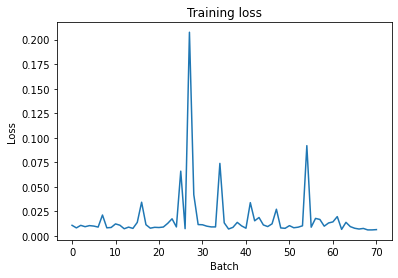

In [87]:
from IPython.display import clear_output
 
train_loss_set = []
train_loss = 0
 
model.train()
 
for step, batch in enumerate(train_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  optimizer.zero_grad()
  
  loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
  
  train_loss_set.append(loss[0].item())  
  
  loss[0].backward()
  
  
  optimizer.step()
 
  train_loss += loss[0].item()
  
  clear_output(True)
  plt.plot(train_loss_set)
  plt.title("Training loss")
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.show()

In [69]:
torch.save(model.state_dict(), save_path + '/model_full_marked_dataset_plus_facts_2.pth')

In [ ]:
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
 
model.eval()
 
valid_preds, valid_labels = [], []
 
for i in range(len(validation_inputs)):
  b_input_ids = torch.tensor(np.array([validation_inputs[i]])).to(device)
  b_labels = torch.tensor(validation_labels[i]).to(device)
  b_input_mask = torch.tensor(np.array([validation_masks[i]])).to(device)
  
  with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
 
  logits = logits[0].detach().to('cpu').numpy()  
  preds = np.argmax(logits, axis=1).item()
  valid_preds.append(preds)
  valid_labels.append(b_labels.to('cpu').numpy().item())

Loss на обучающей выборке: 0.49855


In [ ]:
print("Accuracy на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))
print("f1: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds, average='macro') * 100
))

Accuracy на валидационной выборке: 81.08%
f1: 83.70%


# Test

In [41]:
sentencesTest = []
labelsTest = df_test.ans
 
for text in df_test.task:
  text = text.lower().replace('\n', ' ')
  text = ''.join(c for c in text if c in alphabet)
  text = ' '.join(text.split())
  sentencesTest.append(text)
 
sentencesTest = ["[CLS] " + sentence + " [SEP]" for sentence in sentencesTest]
sentencesTest = np.array(sentencesTest)
labelsTest = np.array(labelsTest)

In [42]:
sentencesTest.shape, sentencesTest[0]

((514,),
 '[CLS] вопрос денис готовится провести соревнования по настольному хоккею и решил распечатать недостающие фигурки на принторе для изготовления одной модели у дениса слишком мало времени поэтому он решает использовать принтера сразу а потом склеить полученные детали у специалиста сейчас в наличии принтеров сколько у него есть вариантов выбора если сначала он настраивает один из принтеров а за ним второй [SEP]')

In [43]:
tokenized_textsTest = [tokenizer.tokenize(sent) for sent in sentencesTest]

In [44]:
len(tokenized_textsTest[0]), tokenized_textsTest[0]

(103,
 ['[CLS]',
  'вопрос',
  'денис',
  'го',
  '##тов',
  '##ится',
  'провести',
  'соревнования',
  'по',
  'нас',
  '##то',
  '##льному',
  'х',
  '##ок',
  '##ке',
  '##ю',
  'и',
  'решил',
  'ра',
  '##сп',
  '##еч',
  '##ата',
  '##ть',
  'не',
  '##до',
  '##ста',
  '##ющие',
  'ф',
  '##и',
  '##гу',
  '##рки',
  'на',
  'при',
  '##нт',
  '##оре',
  'для',
  'из',
  '##го',
  '##тов',
  '##ления',
  'однои',
  'модели',
  'у',
  'денис',
  '##а',
  'слишком',
  'мало',
  'времени',
  'поэтому',
  'он',
  'р',
  '##еш',
  '##ает',
  'использовать',
  'при',
  '##нте',
  '##ра',
  'сразу',
  'а',
  'потом',
  'с',
  '##кле',
  '##ить',
  'полу',
  '##ченные',
  'де',
  '##тали',
  'у',
  'специалист',
  '##а',
  'сеичас',
  'в',
  'на',
  '##ли',
  '##чии',
  'при',
  '##нте',
  '##ров',
  'с',
  '##колько',
  'у',
  'него',
  'есть',
  'вариант',
  '##ов',
  'выбор',
  '##а',
  'если',
  'сначала',
  'он',
  'нас',
  '##тра',
  '##ивает',
  'один',
  'из',
  'при',
  '##нте

In [45]:
tokenized_textsTest = pad_sequences(
  tokenized_textsTest,
  maxlen=max_len_tokenized,
  dtype=object,
  truncating="post",
  padding="post",
  value='[PAD]'
)
 
attention_masksTest = [[1 if i != '[PAD]' else 0 for i in seq] for seq in tokenized_textsTest]
 
input_idsTest = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_textsTest]

In [88]:
test_preds, test_labels = [], []
 
for i in range(len(input_idsTest)):
  b_input_ids = torch.tensor(np.array([input_idsTest[i]])).to(device)
  b_labels = torch.tensor(labelsTest[i]).to(device)
  b_input_mask = torch.tensor(np.array([attention_masksTest[i]])).to(device)
  
  with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
 
  logits = logits[0].detach().to('cpu').numpy()
  preds = np.argmax(logits, axis=1).item()
  test_preds.append(preds)
  test_labels.append(b_labels.to('cpu').numpy().item())

In [89]:
for i in range(len(test_preds)):
  test_preds[i] = catToCatTest[test_preds[i]]

In [90]:
print("Accuracy на тестовой выборке: {0:.2f}%".format(
    accuracy_score(test_labels, test_preds) * 100
))
print("f1: {0:.2f}%".format(
    f1_score(test_labels, test_preds, average='macro') * 100
))

Accuracy на тестовой выборке: 78.99%
f1: 76.35%


# Any test & make csv

In [70]:
def prediction(sentence, max_key_words=1):
  sentence = sentence.lower().replace('\n', ' ').replace('ё', 'е').replace('й', 'и')
  sentence = ''.join(c for c in sentence if c in alphabet)
  sentence = ' '.join(sentence.split()[:max_len_tokenized])
  sentence = '[CLS] ' + sentence + ' [SEP]'
  words = sentence.split()
  tokenized = tokenizer.tokenize(sentence)

  now_word = 0
  now_ind = 0
  token_to_word = []
  for i in tokenized:
    token_to_word.append(now_word)
    for j in range(len(i)):
      if i[j] != words[now_word][now_ind]:
        continue
      now_ind += 1
      if now_ind == len(words[now_word]):
        now_ind = 0
        now_word += 1
  
  ids = [tokenizer.convert_tokens_to_ids(tokenized)]
  ids = torch.tensor(ids)
  ids = ids.to(device)
  label = torch.tensor([0]).to(device)
  with torch.no_grad():
    logits = model(ids, token_type_ids=None, attention_mask=None, labels=label)
  
  ans = logits[1].detach().to('cpu').numpy()
  ans_ind = np.argmax(ans, axis=1).item()
  ans_cat = categories[ans_ind]

  attention = logits[3][11][0][11][0].detach().to('cpu').numpy()
  max_inds = np.flip(np.argsort(attention))
  all_key_words = ['[SEP]', '[CLS]']
  for i in max_inds:
    if words[token_to_word[i]] in all_key_words:
      continue
    all_key_words.append(words[token_to_word[i]])
    if len(all_key_words)-2 == max_key_words:
      break
  return ans_cat, all_key_words[2:]

In [71]:
ans_cat, all_key_words = prediction('1.29. Вороны высиживают яйца три недели. Сколько дней высиживают яйца вороны?', 3)
print(ans_cat)
print(all_key_words)

животные
['вороны', 'высиживают', 'сколько']


In [72]:
ans_csv = []
for i, text in enumerate(df_test.task):
  ans_cat, all_key_words = prediction(text, 3)
  ans_csv.append([i, ans_cat, '; '.join(all_key_words)])

ans_df = pd.DataFrame(ans_csv, columns=['id', 'category', 'keywords'])

In [73]:
ans_df.head(20)

,id,category,keywords
0,0,спорт,настольному; фигурки; хоккею
1,1,животные,собак; сколько; коробок
2,2,спорт,волеиболу; легкои; группы
3,3,животные,описанная; оформил; потратил
4,4,спорт,шестиклассников; самостоятельно; проверьте
5,5,спорт,тетради; отжимании; в
6,6,литература,вычисли; следующие; задания
7,7,спорт,тина; каменистыи; водоросли
8,8,спорт,на; а; машина
9,9,спорт,раздевалки; вычисли; гребцов


In [74]:
ans_df.to_csv(save_path + '/ans.csv', index=False)